In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [3]:
dfParticipants = pd.read_csv("/Users/jakubhajko/Projects/M3RT/saves/reset_csvs/participants.csv", delimiter=",", index_col=0)

In [4]:
dfJudgements = pd.read_csv("/Users/jakubhajko/Projects/M3RT/saves/reset_csvs/triplet_judgements.csv", delimiter=",", index_col=0)

In [5]:
dfTriplets = pd.read_csv("/Users/jakubhajko/Projects/M3RT/saves/reset_csvs/triplets_extended.csv", delimiter=",", index_col=0)

In [6]:
dfAll = dfParticipants.join(dfJudgements.reset_index().set_index("user_id"), how="inner")
dfAll = dfAll.reset_index().set_index("triplet_id").join(dfTriplets, how="inner").reset_index().set_index("judgement_id")

dfAll = dfAll[~((dfAll['clip_cosdist_query_candidate1'] == 1.11) | 
                (dfAll['clip_cosdist_query_candidate2'] == 1.11) | 
                (dfAll['clip_cosdist_candidates'] == 1.11))]
dfAll.shape

(17010, 213)

# Binary judgement analysis
- focusing only on whether left or right choice was more similar
- ignoring indifferent judgements as well as magnitude of user's judgement
- analysis is limited to cosine distance

## Pre-processing data, assessing consistency w.r.t. individual extractors

In [7]:
extractors = dfAll.model.unique()
extractors.sort()
extractors = list(extractors)
extractors = extractors + ['clip','ViT_H_14_laion2b','ViT_SO400M_14_webli','ViT_H_14_dfn5b']
print(extractors)

['CIELABKMeansExctractor_4', 'CIELABPositionalExctractor_regions_2x2', 'CIELABPositionalExctractor_regions_4x4', 'CIELABPositionalExctractor_regions_8x8', 'CLIPExtractor_medium', 'CLIPExtractor_small', 'ConvNeXTExtractor_base', 'ConvNeXTExtractor_large', 'ConvNeXTExtractor_small', 'ConvNeXTExtractor_tiny', 'EfficientNetExtractor_0', 'EfficientNetExtractor_2', 'EfficientNetExtractor_4', 'EfficientNetExtractor_6', 'EfficientNetExtractor_7', 'ImageGPTExtractor_medium', 'ImageGPTExtractor_small', 'RGBHistogramExtractor_256', 'RGBHistogramExtractor_64', 'ResNetV2Extractor_101', 'ResNetV2Extractor_152', 'ResNetV2Extractor_50', 'VANExtractor_base', 'VANExtractor_large', 'VANExtractor_small', 'VANExtractor_tiny', 'VLADExctractor_', 'ViTExtractor_base', 'ViTExtractor_large', 'W2VVExtractor', 'clip', 'ViT_H_14_laion2b', 'ViT_SO400M_14_webli', 'ViT_H_14_dfn5b']


In [8]:
len(extractors)

34

In [9]:
dfAll["candidate1DisplayedOnLeft"] = (dfAll["option_one_path"] == dfAll["candidate1_path"])

In [10]:
columnsToDrop = []
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    # col1e = extractor+"_eucldist_query_candidate1"
    # col2e = extractor+"_eucldist_query_candidate2"
    # opt = extractor+"_eucldist_candidates"
    #dealing with the fact that either of candidate1 and candidate2 can be displayed as left/right option
    dfAll[extractor+"_option_left_dist"] = dfAll[col2]
    dfAll[extractor+"_option_right_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_left_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_right_dist"] = dfAll[col2]
    
    #assessing consistency of the model with human judgement
    right_option_better = ((dfAll[extractor+"_option_left_dist"] > dfAll[extractor+"_option_right_dist"]))
    dfAll["better_for_"+extractor] = right_option_better.astype(int) * 2 - 1
    
    dfAll["same_as_model_"+extractor] = dfAll["simplified_choice"] == dfAll["better_for_"+extractor]
    
    #cleaning the data frame
    columnsToDrop.extend([col1,col2])    
dfConsistency = dfAll.drop(columnsToDrop,axis=1)   
dfConsistency.head(3)

,triplet_id,user_id,age_group,education,ml_expert,choice,simplified_choice,option_one_path,option_two_path,time_spent,handheld,window_width,window_height,user_agent,model,target_path,candidate1_path,candidate2_path,candidate1_bin,candidate2_bin,W2VVExtractor_cosdist_candidates,W2VVExtractor_eucldist_query_candidate1,W2VVExtractor_eucldist_query_candidate2,W2VVExtractor_eucldist_candidates,CIELABPositionalExctractor_regions_2x2_cosdist_candidates,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate1,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate2,CIELABPositionalExctractor_regions_2x2_eucldist_candidates,VLADExctractor__cosdist_candidates,VLADExctractor__eucldist_query_candidate1,VLADExctractor__eucldist_query_candidate2,VLADExctractor__eucldist_candidates,RGBHistogramExtractor_256_cosdist_candidates,RGBHistogramExtractor_256_eucldist_query_candidate1,RGBHistogramExtractor_256_eucldist_query_candidate2,RGBHistogramExtractor_256_eucldist_candidates,ConvNeXTExtractor_tiny_cosdist_candidates,ConvNeXTExtractor_tiny_eucldist_query_candidate1,ConvNeXTExtractor_tiny_eucldist_query_candidate2,ConvNeXTExtractor_tiny_eucldist_candidates,ViTExtractor_base_cosdist_candidates,ViTExtractor_base_eucldist_query_candidate1,ViTExtractor_base_eucldist_query_candidate2,ViTExtractor_base_eucldist_candidates,EfficientNetExtractor_0_cosdist_candidates,EfficientNetExtractor_0_eucldist_query_candidate1,EfficientNetExtractor_0_eucldist_query_candidate2,EfficientNetExtractor_0_eucldist_candidates,ConvNeXTExtractor_small_cosdist_candidates,ConvNeXTExtractor_small_eucldist_query_candidate1,ConvNeXTExtractor_small_eucldist_query_candidate2,ConvNeXTExtractor_small_eucldist_candidates,CIELABPositionalExctractor_regions_4x4_cosdist_candidates,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate1,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate2,CIELABPositionalExctractor_regions_4x4_eucldist_candidates,EfficientNetExtractor_4_cosdist_candidates,EfficientNetExtractor_4_eucldist_query_candidate1,EfficientNetExtractor_4_eucldist_query_candidate2,EfficientNetExtractor_4_eucldist_candidates,ConvNeXTExtractor_base_cosdist_candidates,ConvNeXTExtractor_base_eucldist_query_candidate1,ConvNeXTExtractor_base_eucldist_query_candidate2,ConvNeXTExtractor_base_eucldist_candidates,RGBHistogramExtractor_64_cosdist_candidates,RGBHistogramExtractor_64_eucldist_query_candidate1,RGBHistogramExtractor_64_eucldist_query_candidate2,RGBHistogramExtractor_64_eucldist_candidates,CLIPExtractor_medium_cosdist_candidates,CLIPExtractor_medium_eucldist_query_candidate1,CLIPExtractor_medium_eucldist_query_candidate2,CLIPExtractor_medium_eucldist_candidates,VANExtractor_base_cosdist_candidates,VANExtractor_base_eucldist_query_candidate1,VANExtractor_base_eucldist_query_candidate2,VANExtractor_base_eucldist_candidates,ResNetV2Extractor_101_cosdist_candidates,ResNetV2Extractor_101_eucldist_query_candidate1,ResNetV2Extractor_101_eucldist_query_candidate2,ResNetV2Extractor_101_eucldist_candidates,ResNetV2Extractor_152_cosdist_candidates,ResNetV2Extractor_152_eucldist_query_candidate1,ResNetV2Extractor_152_eucldist_query_candidate2,ResNetV2Extractor_152_eucldist_candidates,EfficientNetExtractor_7_cosdist_candidates,EfficientNetExtractor_7_eucldist_query_candidate1,EfficientNetExtractor_7_eucldist_query_candidate2,EfficientNetExtractor_7_eucldist_candidates,ImageGPTExtractor_medium_cosdist_candidates,ImageGPTExtractor_medium_eucldist_query_candidate1,ImageGPTExtractor_medium_eucldist_query_candidate2,ImageGPTExtractor_medium_eucldist_candidates,ResNetV2Extractor_50_cosdist_candidates,ResNetV2Extractor_50_eucldist_query_candidate1,ResNetV2Extractor_50_eucldist_query_candidate2,ResNetV2Extractor_50_eucldist_candidates,ConvNeXTExtractor_large_cosdist_candidates,ConvNeXTExtractor_large_eucldist_query_candidate1,ConvNeXTExtractor_large_eucldist_query_candidate2,ConvNeXTExtractor_large_eucldist_candidates,EfficientNetExtractor_2_cosdist_candidates,Effi

In [11]:
dfConsistencyNonUnknown = dfConsistency.loc[dfConsistency.simplified_choice!=0]

## Evaluation variant 1: all user judgement decisions counts equally
- if a tripplet is judged multiple times via multiple participants, each time is calculated separately

In [14]:
extrNames = []
scores = []
for extractor in extractors:
    name = "same_as_model_"+extractor
    extrNames.extend([extractor]*dfConsistencyNonUnknown.shape[0])
    scores.extend(dfConsistencyNonUnknown[name].values.tolist())  
dfScores = pd.DataFrame({"Extractor":extrNames,"consistent":scores})
dfScores

,Extractor,consistent
0,CIELABKMeansExctractor_4,False
1,CIELABKMeansExctractor_4,True
2,CIELABKMeansExctractor_4,True
3,CIELABKMeansExctractor_4,False
4,CIELABKMeansExctractor_4,True
...,...,...
477593,ViT_H_14_dfn5b,True
477594,ViT_H_14_dfn5b,False
477595,ViT_H_14_dfn5b,True
477596,ViT_H_14_dfn5b,True


In [49]:
dfScores.groupby("Extractor")["consistent"].sum()
# dfScores[dfScores["Extractor"] == 'ViT_H_14_dfn5b']

Extractor
CIELABKMeansExctractor_4                   8321
CIELABPositionalExctractor_regions_2x2     8886
CIELABPositionalExctractor_regions_4x4     8937
CIELABPositionalExctractor_regions_8x8     8845
CLIPExtractor_medium                      10225
CLIPExtractor_small                       10150
ConvNeXTExtractor_base                    10293
ConvNeXTExtractor_large                   10158
ConvNeXTExtractor_small                   10237
ConvNeXTExtractor_tiny                    10236
EfficientNetExtractor_0                   10374
EfficientNetExtractor_2                   10255
EfficientNetExtractor_4                   10106
EfficientNetExtractor_6                    9996
EfficientNetExtractor_7                    9879
ImageGPTExtractor_medium                   9374
ImageGPTExtractor_small                    9372
RGBHistogramExtractor_256                  8586
RGBHistogramExtractor_64                   8640
ResNetV2Extractor_101                     10199
ResNetV2Extractor_152         

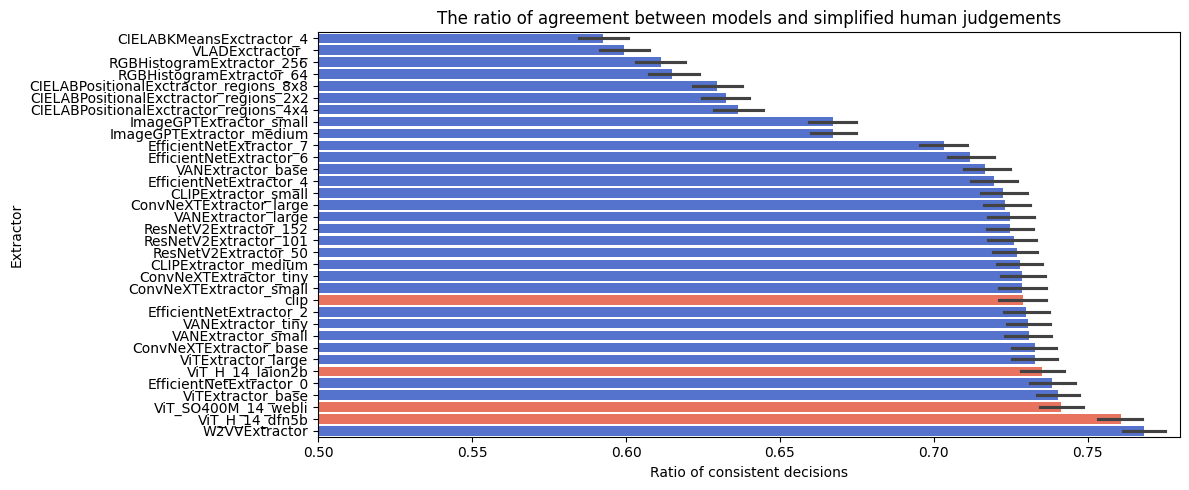

In [41]:

highlight = 'tomato'
default = 'royalblue'

colors = ([default]*22) + [highlight] + ([default]*5) + [highlight,default,default,highlight,highlight,default] 


plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfScores
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor")["consistent"].sum().sort_values().index,
            palette=colors)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.5,0.78)

plt.tight_layout()
plt.savefig("overall_consistentRatio.pdf",dpi=600)
plt.show()

Notable points:
- W2VV best-performing, consistent with the preliminary study
- Quite often, smaller DL models of the same architecture perform better than the larger ones (e.g., EfficientNet)
- Overall, deep learning variants outperform shallow color-based and texture-based embeddings
- All extractors performed better than random guessing
- In general, the judgement consistency is rather weak for low-level models; not so bad for high-level models, but still below human consistency (around/above 0.8)

In [43]:
extractorsOrder = dfScores.groupby("Extractor")["consistent"].sum().sort_values().index
best_model = extractorsOrder[-1]
worst_model = extractorsOrder[0]
mid_model = extractorsOrder[extractorsOrder.shape[0]//2]
worst_model

'CIELABKMeansExctractor_4'

In [44]:
top_models = extractorsOrder[-3:].tolist()

## Evaluation variant 2: each aggregated per-triplet decision counts equally
- only triplets with 2+ judgements kept
- sign of the mean judgment considered

In [45]:
minJudgements = 2

tripletCounts = dfAll.groupby("triplet_id")["user_id"].count()
tripletCounts = tripletCounts.loc[tripletCounts >= minJudgements]
dfReduced = dfAll.loc[dfAll.triplet_id.isin(tripletCounts.index)].copy()

In [46]:
sideOfCandidate1 = ((dfReduced.candidate1DisplayedOnLeft.astype(int)+1) % 2) *2-1

dfReduced["candidate1_preference"] = (sideOfCandidate1 == dfReduced.simplified_choice).astype(int)
dfReduced["candidate2_preference"] = (-sideOfCandidate1 == dfReduced.simplified_choice).astype(int)

dfTripletAgg = dfReduced.groupby("triplet_id").mean()
dfTripletAgg["candidate_choice"] = dfTripletAgg.candidate2_preference - dfTripletAgg.candidate1_preference
print(dfTripletAgg.shape)
dfTripletAgg = dfTripletAgg.loc[dfTripletAgg.candidate_choice!=0]
dfTripletAgg.candidate_choice = np.sign(dfTripletAgg.candidate_choice)
print(dfTripletAgg.shape)

TypeError: agg function failed [how->mean,dtype->object]

- in about 10% of cases, aggregated judgements do not tend to prefer either option

In [46]:
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    dfTripletAgg["better_for_"+extractor] = (dfTripletAgg[col2] < dfTripletAgg[col1]).astype(int) * 2 - 1
    
    dfTripletAgg["same_as_model_"+extractor] = dfTripletAgg["candidate_choice"] == dfTripletAgg["better_for_"+extractor]

In [47]:
extrNames = []
scores = []
for extractor in extractors:
    name = "same_as_model_"+extractor
    extrNames.extend([extractor]*dfTripletAgg.shape[0])
    scores.extend(dfTripletAgg[name].values.tolist())  
dfScores = pd.DataFrame({"Extractor":extrNames,"consistent":scores})
dfScores.head(3)

,Extractor,consistent
0,CIELABKMeansExctractor_4,True
1,CIELABKMeansExctractor_4,False
2,CIELABKMeansExctractor_4,True


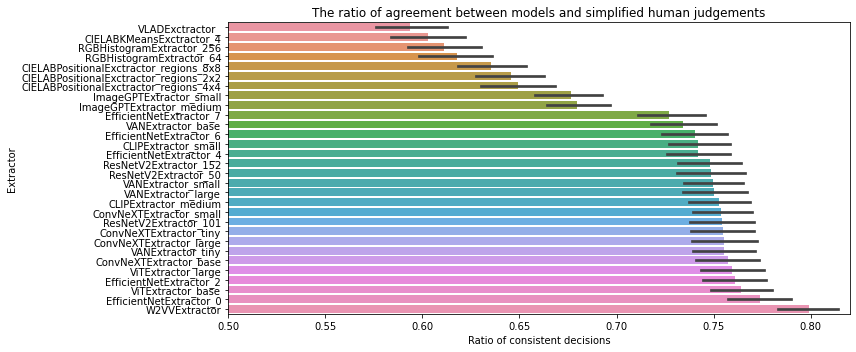

In [48]:
plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfScores
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor")["consistent"].sum().sort_values().index)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.5,0.82)

#ax.set_xlim(0.0,humanAgreement+0.05)
#plt.vlines(x=humanAgreement, ymin=0, ymax=len(extractors)-1, color="red")

plt.tight_layout()
plt.savefig("img/overallResults/overall_consistentRatio_aggregated_on_triplets.pdf")
plt.show()

- no substantial differences in ordering of methods

## The level of human agreement in full judgements
- evaluated as a standard deviation w.r.t. triplets with 5 or more judgements

In [49]:
dfAll["candidate1_preference"] = 0
dfAll.loc[dfAll.candidate1DisplayedOnLeft, "candidate1_preference"] = -dfAll.choice
dfAll.loc[~dfAll.candidate1DisplayedOnLeft, "candidate1_preference"] = dfAll.choice
#positive values indicate that users prefered candidate1 as more similar to query

In [50]:
minJudgements = 5

tripletCounts = dfAll.groupby("triplet_id")["user_id"].count()
tripletCounts = tripletCounts.loc[tripletCounts >= minJudgements]
dfReduced = dfAll.loc[dfAll.triplet_id.isin(tripletCounts.index)].copy()

In [51]:
dfReduced.shape,dfReduced.triplet_id.unique().shape,dfReduced.loc[dfReduced["class"]=="scuba"].triplet_id.unique().shape,dfReduced.loc[dfReduced["class"]=="wedding"].triplet_id.unique().shape

((7397, 323), (962,), (334,), (381,))

- still sufficient volumes of triplets for each sub-domain to run the analysis
### STD of human per-triplet judgments

In [52]:
statsResults = dfReduced.groupby("triplet_id")["candidate1_preference"].aggregate(["count","mean","median","std"])
statsResults["std"].describe()

count    962.000000
mean       0.829848
std        0.448792
min        0.000000
25%        0.523436
50%        0.808435
75%        1.153637
max        2.049390
Name: std, dtype: float64

In [53]:
statsResultsScuba = dfReduced.loc[dfReduced["class"]=="scuba"].groupby("triplet_id")["candidate1_preference"].aggregate(["count","mean","median","std"])
statsResultsScuba["std"].describe()

count    334.000000
mean       0.793815
std        0.490294
min        0.000000
25%        0.447214
50%        0.707107
75%        1.172602
max        2.000000
Name: std, dtype: float64

In [54]:
statsResultsWedding = dfReduced.loc[dfReduced["class"]=="wedding"].groupby("triplet_id")["candidate1_preference"].aggregate(["count","mean","median","std"])
statsResultsWedding["std"].describe()

count    381.000000
mean       0.886260
std        0.432660
min        0.000000
25%        0.547723
50%        0.836660
75%        1.169045
max        2.049390
Name: std, dtype: float64

In [55]:
statsResultsGeneral = dfReduced.loc[dfReduced["class"]=="general"].groupby("triplet_id")["candidate1_preference"].aggregate(["count","mean","median","std"])
statsResultsGeneral["std"].describe()

count    247.000000
mean       0.791557
std        0.405085
min        0.000000
25%        0.569443
50%        0.760886
75%        1.036393
max        1.974842
Name: std, dtype: float64

# Correlation of feature extractors with detailed human judgements
- judgements are considered as numeric values from -2 to +2 corresponding to a 5-point likert scale
- models are treated w.r.t. cosine difference in the distance of respective candidates

In [56]:
columnsToDrop = []
minDistance = 1e-5
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    opts = extractor+"_cosdist_candidates"
    dfAll.loc[dfAll[opts]==0,opts] = minDistance # fixing division by zero
    
    #positive values indicate that candidate1 is more similar than candidate2 (i.e., had lower distance)
    dfAll["distance_diff_"+extractor] = (dfAll[col2] - dfAll[col1])
    dfAll["distance_diff_maxNorm"+extractor] = (dfAll[col2] - dfAll[col1])/dfAll[[col1, col2]].max(axis=1)
    dfAll["distance_diff_optionsDiffNorm"+extractor] = (dfAll[col2] - dfAll[col1])/dfAll[opts]

Three variants of the distance metric: 
 - dist(q, c1) - dist(q, c2)
 - (dist(q, c1) - dist(q, c2)) / max(dist(q, c1),dist(q, c2))
 - (dist(q, c1) - dist(q, c2)) / dist(c1, c2)

In [57]:
dfAll = dfAll.fillna(0)

In [58]:
from scipy.stats import pearsonr, spearmanr

resultsDistanceDiff = {}
resultsDistanceDiffNorm = {}
resultsDistanceDiffOptNorm = {}

for extractor in extractors:
    resultsDistanceDiff[extractor] = pearsonr(dfAll["distance_diff_"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffNorm[extractor] = pearsonr(dfAll["distance_diff_maxNorm"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffOptNorm[extractor] = pearsonr(dfAll["distance_diff_optionsDiffNorm"+extractor],dfAll["candidate1_preference"])[0]

dfPearsonCorrelationResults = pd.DataFrame([resultsDistanceDiff,resultsDistanceDiffNorm,resultsDistanceDiffOptNorm],index=["distanceDiff","maxNormalizedDistanceDiff","optionsDistanceNormalizedDiff"]).T
dfPearsonCorrelationResults.sort_values("distanceDiff")

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABKMeansExctractor_4,0.178252,0.219457,0.157355
VLADExctractor_,0.192989,0.216862,0.210039
CIELABPositionalExctractor_regions_2x2,0.198456,0.274104,0.165577
RGBHistogramExtractor_256,0.212271,0.226409,0.204444
CIELABPositionalExctractor_regions_4x4,0.224366,0.301111,0.218754
RGBHistogramExtractor_64,0.226327,0.239490,0.210726
CIELABPositionalExctractor_regions_8x8,0.232904,0.303727,0.233625
ImageGPTExtractor_small,0.258688,0.337967,0.239144
ImageGPTExtractor_medium,0.283113,0.348704,0.266328
CLIPExtractor_small,0.404795,0.467544,0.436050


In [59]:
dfPearsonCorrelationResults.mean()

distanceDiff                     0.404157
maxNormalizedDistanceDiff        0.428029
optionsDistanceNormalizedDiff    0.400234
dtype: float64

Notable points:
- W2VV++ is the most consistent of all extractors also w.r.t. correlation with detailed human judgments
- out of the considered distance variants, the one normalized by max(dist(q,c1),dist(q,c2)) provide highest overall correlations (the differences are not large, but rather consistent throughout all extractors)

In [61]:
resultsDistanceDiff = {}
resultsDistanceDiffNorm = {}
resultsDistanceDiffOptNorm = {}
from scipy.stats import pearsonr
for extractor in extractors:
    resultsDistanceDiff[extractor] = spearmanr(dfAll["distance_diff_"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffNorm[extractor] = spearmanr(dfAll["distance_diff_maxNorm"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffOptNorm[extractor] = spearmanr(dfAll["distance_diff_optionsDiffNorm"+extractor],dfAll["candidate1_preference"])[0]

dfSpearmanCorrelationResults = pd.DataFrame([resultsDistanceDiff,resultsDistanceDiffNorm,resultsDistanceDiffOptNorm],index=["distanceDiff","maxNormalizedDistanceDiff","optionsDistanceNormalizedDiff"]).T
dfSpearmanCorrelationResults.sort_values("distanceDiff")

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABKMeansExctractor_4,0.188215,0.223440,0.185758
VLADExctractor_,0.205192,0.219669,0.213735
RGBHistogramExtractor_256,0.214035,0.226484,0.216358
RGBHistogramExtractor_64,0.223111,0.238135,0.222178
CIELABPositionalExctractor_regions_2x2,0.231890,0.284391,0.222872
CIELABPositionalExctractor_regions_4x4,0.249651,0.300376,0.254529
CIELABPositionalExctractor_regions_8x8,0.250750,0.297349,0.260305
ImageGPTExtractor_small,0.294671,0.348458,0.283222
ImageGPTExtractor_medium,0.307351,0.358114,0.302403
CLIPExtractor_small,0.434004,0.468055,0.445718


In [62]:
dfSpearmanCorrelationResults.mean()

distanceDiff                     0.415996
maxNormalizedDistanceDiff        0.431038
optionsDistanceNormalizedDiff    0.414115
dtype: float64

Results w.r.t. Spearman correlation are highly similar to those of Pearson's correlation

# Correlations between feature extractors

In [63]:
cnames=[]
for extractor in extractors:
    cnames.append("distance_diff_maxNorm"+extractor)
dfModelsDistanceDiff = dfAll[cnames]
dfModelsDistanceDiff.shape

(17026, 30)

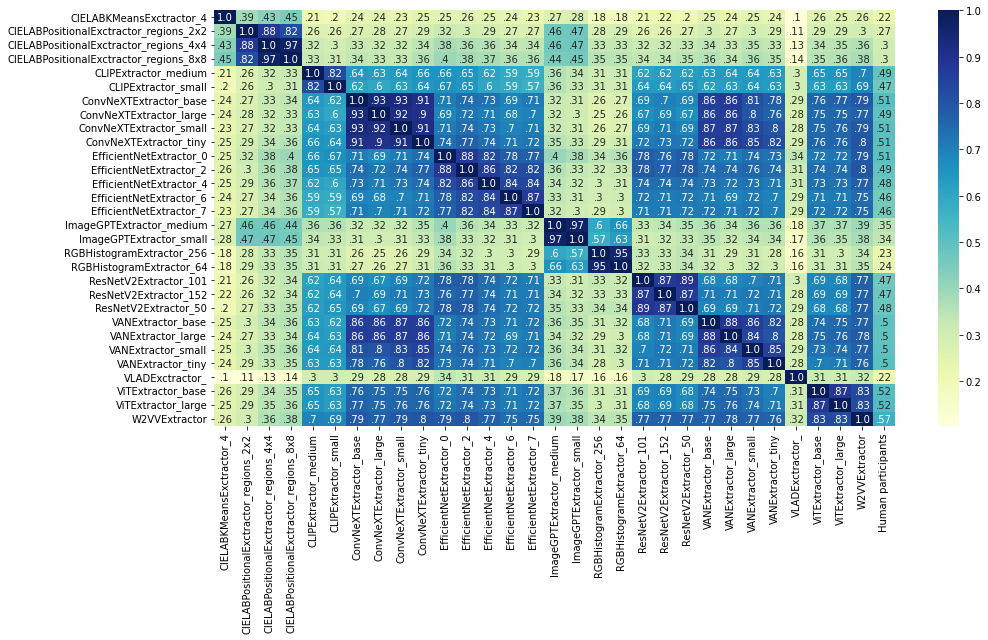

In [65]:
corrDF = dfModelsDistanceDiff.corr()
corrDF.columns = corrDF.columns.str.replace("distance_diff_maxNorm","")
corrDF.index = corrDF.index.str.replace("distance_diff_maxNorm","")
corrDF["Human participants"] = dfPearsonCorrelationResults["maxNormalizedDistanceDiff"]
annot_arr = np.around(corrDF.values,2).astype('str')
annot_arr = np.char.replace(annot_arr,"0.",".")
plt.figure(figsize=(15,9))
sns.heatmap(corrDF,  cmap="YlGnBu", annot=annot_arr, fmt="s")

plt.tight_layout()
plt.savefig("img/overallResults/overall_correlationmatrix.pdf")
plt.show()

Notable points:
- much larger correlations among models from the same sub-class than model-human
- different sizes of the same model usually exhibit very high correlation
- all DL approaches correlate with each other (except for ImageGPT, where lower layers were utilized). In contrast ImageGPT correlates to low-level representations such as RGB histogram and LAB positional